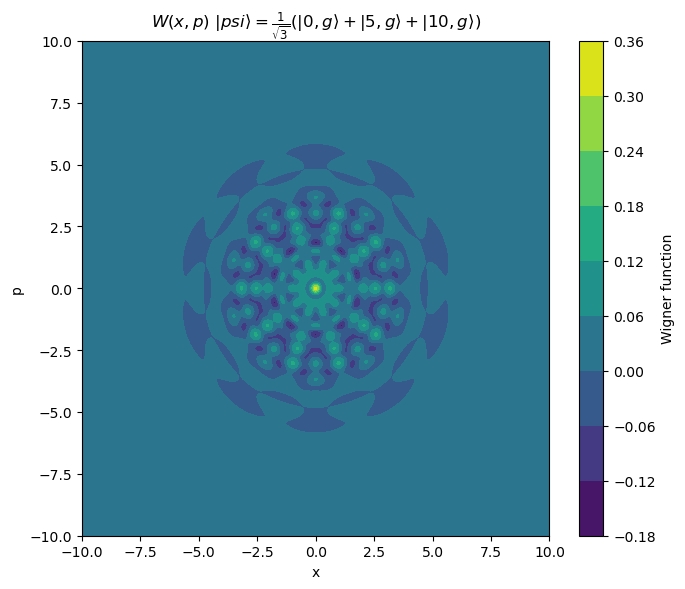

In [1]:
#kako izgleda cilj naloge 
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qu
import matplotlib.pyplot as plt
import numpy as np
from qutip import about, basis, destroy, mesolve, qeye, sigmaz, tensor
%matplotlib inline

M = 10
dim = M+1 #trunkacija Hilbertovega prostora 
psi  = (tensor(basis(dim, 0), basis(2, 0))+  tensor(basis(dim, 5), basis(2, 0)) +  tensor(basis(dim, 10), basis(2, 0))).unit() #normalizirana valovna funkcija 
rho = qu.ket2dm(psi)

xvec = np.linspace(-10, 10, 500)
Wigner = qu.wigner(rho, xvec, xvec)

fig, ax = plt.subplots(figsize=(7,6))
contour = ax.contourf(xvec, xvec, Wigner)
fig.colorbar(contour, ax=ax, label='Wigner function')
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_title(r"$W(x, p)$ $|psi\rangle = \frac{1}{\sqrt{3}} (|0, g \rangle + |5, g \rangle + |10, g \rangle )$")
plt.tight_layout()

In [5]:
#podatki iz profesorjevega githuba 
g = [
    7.937048799479558880e+00,
    1.009239192383891925e+01,
    6.154037432726686685e-01,
    7.411581560123039480e-01,
    7.259016445487089797e-01,
    4.564517282016632649e+00,
    1.786966805559012439e+00,
    5.553603672697957627e-01,
    5.235987755982989267e-01,
    4.967294132898050774e-01]

r = [
    4.414048844206741151e+00,
    7.932139438869589831e+00,
    1.143707047998263393e+00,
    4.600384915994120583e+00,
    1.124193141669553642e+00,
    4.615662605575688637e+00,
    1.070891504279875583e+01,
    1.170189568419079729e+00,
    7.853981633974482790e+00,
    7.853981633974482790e+00]

phi = [
        2.990654483905298761e-14,
        -5.973255132502678621e-16,
        2.309086202225754193e-14,
        1.598247089421003724e-15,
        -3.141592653589793116e+00,
        3.998392607703562203e-15,
        1.038400088085067694e-16,
        0.000000000000000000e+00,
        0.000000000000000000e+00,
        0.000000000000000000e+00]

theta = [
        -3.141592653589785122e+00,
        1.813995235821373297e-14,
        -3.141592653589773132e+00,
        1.722956010265286019e-14,
        -5.823171352714197498e-15,
        4.918804186385745618e-15,
        -3.141592653589790896e+00,
        -3.141592653589793116e+00,
        0.000000000000000000e+00,
        0.000000000000000000e+00]

In [6]:
M = 10
tstar = 2*M 
dim = M + 1 
tlist = np.linspace(0, tstar, 2000)
tau = tstar/(2*M)

psi0  = tensor(basis(dim, 0), basis(2, 0))

a = tensor(destroy(dim), qeye(2))
adag = a.dag()
sm = tensor(qeye(dim), destroy(2).dag()) 

# H = r(t) \sigma_{+} + g(t) a \sigma_{+} + r^{*}(t) \sigma_{-} + g^{*}(t) a^{+} \sigma_{-}
# H = r(t) H1 + g(t) H2+ r^{*}(t) H3 + g^{*}(t) aH4

#razdeljen hamiltonjan
H1 = sm.dag()
H2 = a * sm.dag() 
H3 = sm
H4 = adag * sm

rj = lambda j : r[j] * np.exp(1j * theta[j])
rj_conj = lambda j : r[j] * np.exp(-1j * theta[j])
gj = lambda j : g[j] * np.exp(1j * phi[j])
gj_conj = lambda j : g[j] * np.exp(-1j * phi[j])

def lihi_casovni_interval(t): #ali je 2( j - 1) tau < t < (2j - 1) tau
    return sum([2 * (j - 1) * tau < t < (2*j -1) * tau for j in range(1, M + 1)]) == 1 

def sodi_casovni_interval(t): #ali je (2j - 1) tau < t < 2j tau 
    return sum([(2 * j - 1) * tau < t < 2 * j * tau for j in range(1, M + 1)]) == 1

def lihi_indeks_j(t): #za t določi pripadajoči j 
    return np.where(np.array([2 * (j - 1) * tau < t < (2*j -1) * tau for j in range(1, M + 1)]))[0][0]

def sodi_indeks_j(t): #za t določi pripadajoči j
    return np.where([(2 * j - 1) * tau < t < 2 * j * tau for j in range(1, M + 1)])[0][0]

rt = lambda t : rj(lihi_indeks_j(t)) if lihi_casovni_interval(t) else 0
rt_conj = lambda t : rj_conj(lihi_indeks_j(t)) if lihi_casovni_interval(t) else 0
gt = lambda t : gj(sodi_indeks_j(t)) if sodi_casovni_interval(t) else 0
gt_conj = lambda t : gj_conj(sodi_indeks_j(t)) if sodi_casovni_interval(t) else 0


e_ops = [a.dag() * a, sm.dag() * sm]

output = mesolve([[H1, rt], [H2, gt], [H3, rt_conj], [H4, gt_conj]], psi0, tlist, e_ops = e_ops, options={'store_states': True})

/opt/anaconda3/envs/JCM_env/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/JCM_env/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


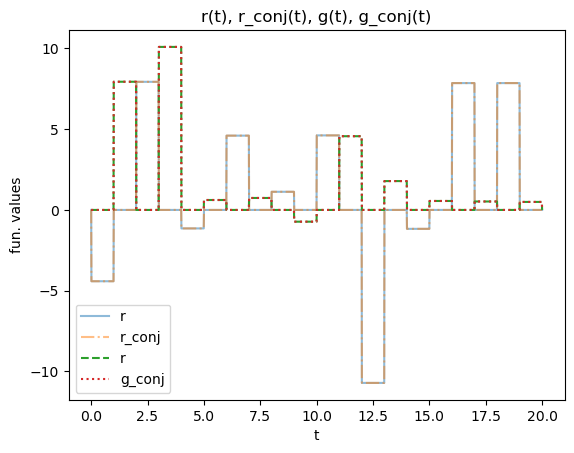

In [7]:
#preverimo pravilnost implemetnacij funkcij r(t), g(t), r*(t), g*(t)
def g_and_r_values_in_t(tlist):
    rt_list = []
    rt_conj_list = []
    gt_list = []
    gt_conj_list  = []
    for t in tlist: 
        rt_list.append(rt(t))
        rt_conj_list.append(rt_conj(t))
        gt_list.append(gt(t))
        gt_conj_list.append(gt_conj(t))

    return np.array(rt_list), np.array(rt_conj_list), np.array(gt_list), np.array(gt_conj_list)


rt_list, rt_conj_list, gt_list, gt_conj_list  = g_and_r_values_in_t(tlist)

plt.plot(tlist, rt_list, alpha=0.5, label="r")
plt.plot(tlist, rt_conj_list,ls="dashdot", alpha=0.5, label="r_conj")
plt.plot(tlist, gt_list, ls="dashed", label="r")
plt.plot(tlist, gt_conj_list, ls='dotted',  label="g_conj")
plt.xlabel("t")
plt.ylabel("fun. values")
plt.title("r(t), r_conj(t), g(t), g_conj(t)")
plt.legend()

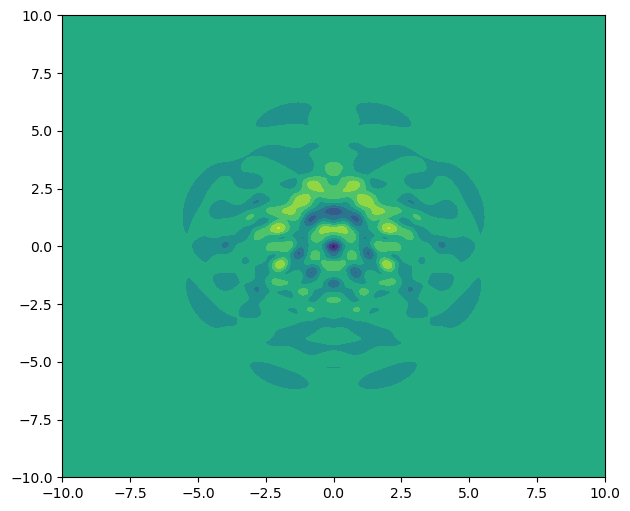

In [8]:
#wigner ob t*
rhos = [qu.ket2dm(output.states[i]) for i in range(len(output.states))]
xvec = np.linspace(-10, 10, 500)
Wigner = qu.wigner(rhos[-1], xvec, xvec)

fig, ax = plt.subplots(figsize=(7,6))
contour = ax.contourf(xvec, xvec, Wigner)

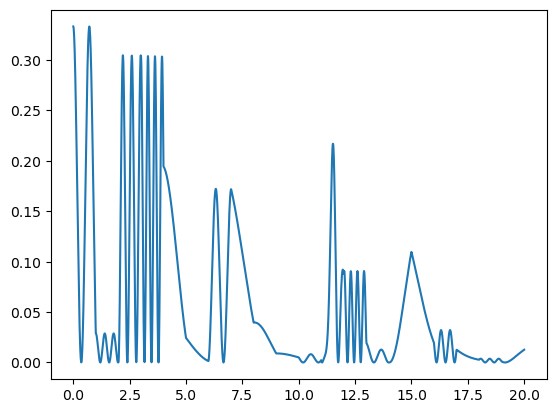

In [9]:
#fidelity
psi_zvezda = (tensor(basis(dim, 0), basis(2, 0))+  tensor(basis(dim, 5), basis(2, 0)) +  tensor(basis(dim, 10), basis(2, 0))).unit()
rho_zveza = qu.ket2dm(psi_zvezda)
fidelity = [np.real((rhos[i] * rho_zveza).tr()) for i in range(len(rhos))]
plt.plot(tlist, fidelity)